<a href="https://colab.research.google.com/github/MoonJaeHoon/dacon_parking_demand/blob/master/EDA2_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ## Plot 한글
# # Step 1. Matplotlib 업그레이드
# !pip install matplotlib -U

# # Step 2. 한글 설치 및 사용 설정
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# # Step 3. 런타임 재시작

In [2]:
import os
import pickle
from tqdm import tqdm, tqdm_notebook
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import random
import numpy as np
from pprint import  pprint
import warnings
warnings.filterwarnings('ignore')
# 한글폰트 설정, 그래프 마이너스 표시 설정
import matplotlib
from matplotlib import font_manager, rc
from matplotlib import pyplot as plt
import platform
import seaborn as sns

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['axes.unicode_minus'] = False

seed=47
def set_seed(seed: int = 42, contain_cuda: bool = False):
    random.seed(seed)
    np.random.seed(seed)

    # if contain_cuda:
    #     torch.backends.cudnn.deterministic = True
    #     torch.backends.cudnn.benchmark = False

    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    print(f"seed set as {seed}")
set_seed(seed)

seed set as 47


In [3]:
cd /content/drive/MyDrive/dacon_parking_data

/content/drive/MyDrive/dacon_parking_data


In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
age_gender_info = pd.read_csv('./data/age_gender_info.csv')
submission = pd.read_csv('./data/sample_submission.csv')
print(f"train.shape : {train.shape}")
print(f"test.shape : {test.shape}")

# print(f"len(train.columns) : {len(train.columns)}")
# print(f"len(test.columns) : {len(test.columns)}")

train.shape : (2952, 15)
test.shape : (1022, 14)


In [5]:
# 결측치가 1개라도 존재하는 row들
exist_nan_row_idx = train.isnull()[train.isnull().any(axis=1)].index
# 결측치가 전혀 없었던 단지코드들
no_nan_danjicode = list(set(train['단지코드'].unique()) - set(train.loc[exist_nan_row_idx,:]['단지코드'].unique()))
print(len(no_nan_danjicode))
print(no_nan_danjicode)

378
['C1155', 'C1320', 'C1672', 'C2620', 'C1048', 'C1659', 'C1502', 'C2470', 'C1592', 'C1866', 'C2066', 'C1281', 'C2256', 'C2142', 'C2351', 'C1516', 'C1713', 'C1163', 'C2377', 'C2515', 'C1490', 'C2563', 'C1102', 'C2040', 'C1940', 'C1218', 'C1406', 'C2661', 'C1176', 'C2173', 'C2446', 'C1000', 'C2329', 'C2401', 'C2483', 'C1171', 'C1258', 'C2259', 'C2659', 'C1845', 'C1046', 'C1910', 'C2587', 'C1689', 'C1916', 'C2188', 'C2251', 'C1344', 'C1819', 'C1085', 'C2071', 'C2082', 'C1426', 'C2070', 'C1802', 'C1566', 'C1889', 'C1660', 'C2046', 'C2431', 'C1328', 'C2605', 'C1706', 'C2358', 'C1685', 'C1065', 'C2013', 'C2568', 'C1565', 'C2631', 'C2346', 'C2596', 'C1757', 'C1994', 'C2298', 'C2274', 'C1641', 'C1234', 'C1724', 'C1095', 'C2020', 'C2530', 'C1941', 'C2276', 'C1738', 'C1638', 'C1663', 'C2556', 'C1379', 'C2097', 'C2099', 'C1743', 'C1319', 'C2232', 'C2133', 'C2488', 'C1939', 'C1585', 'C1394', 'C1057', 'C1136', 'C2389', 'C2371', 'C1537', 'C1979', 'C1544', 'C1268', 'C1744', 'C2032', 'C1084', 'C266

In [6]:
print("Train set NULL")
print({k:v for k,v in train.isnull().sum().to_dict().items() if v!=0})
print("Test set NULL")
print({k:v for k,v in test.isnull().sum().to_dict().items() if v!=0})

Train set NULL
{'임대보증금': 569, '임대료': 569, '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 211, '도보 10분거리 내 버스정류장 수': 4}
Test set NULL
{'자격유형': 2, '임대보증금': 180, '임대료': 180, '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 42}


In [7]:
# 임대보증금과 임대료는 '-'을 null로 바꾼 후 float로 타입 변경
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [8]:
# 임대보증금과 임대료가 NULL인 경우는 0으로 대체하는 것이 좋아보임
train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

In [9]:
print("Train set NULL")
print({k:v for k,v in train.isnull().sum().to_dict().items() if v!=0})
print("Test set NULL")
print({k:v for k,v in test.isnull().sum().to_dict().items() if v!=0})

Train set NULL
{'도보 10분거리 내 지하철역 수(환승노선 수 반영)': 211, '도보 10분거리 내 버스정류장 수': 4}
Test set NULL
{'자격유형': 2, '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 42}


In [10]:
cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

In [11]:
test[test.단지코드=='C2411'] # A로 채우면 될듯

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000.0,171480.0,0.0,2.0,840.0


In [12]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'

In [13]:
test[test.단지코드=='C2253'].head() # 임대보증금과 임대료가 존재하는 경우 자격유형이 C => C로 채우면 될듯

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,0.0,0.0,0.0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,0.0,0.0,0.0,2.0,173.0


In [14]:
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

In [15]:
print("Train set NULL")
print({k:v for k,v in train.isnull().sum().to_dict().items() if v!=0})
print("Test set NULL")
print({k:v for k,v in test.isnull().sum().to_dict().items() if v!=0})

Train set NULL
{}
Test set NULL
{}


+ 중복되는 데이터는 제거하고 분석을 진행하는 것이 좋아보임 (일단 중복제거 안하고 진행해보기)

In [16]:
# train = train.drop_duplicates()
# test = test.drop_duplicates()

In [17]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0


### 자격유형 category 묶기

> B, F, O는 다른 어떤 항목에 포함시켜 무조건 묶어줘야함


1. O는 'J', 'L', 'K', 'N', 'M', 'O'로 묶어서 '행복주택_공급대상'으로
2. B는 'B','H','G'로 묶어서 '국민임대_공급대상'으로
3. F는 'C','I','F'로 묶어서 '영구임대_공급대상'으로

In [18]:
# 자격유형의 항목들 중 train에는 있지만 test에는 존재하지 않는 항목들이 존재.
pd.concat([train.자격유형.value_counts(), test.자격유형.value_counts()], axis=1)
# B, F, O

,자격유형,자격유형
A,1801,573.0
D,569,180.0
H,155,92.0
J,114,84.0
C,95,35.0
I,49,7.0
E,37,10.0
L,33,12.0
K,33,16.0
N,30,10.0


1. 'J', 'L', 'K', 'N', 'M', 'O' 묶어버리기 => 행복주택_공급대상

In [19]:
# 'J', 'L', 'K', 'N', 'M', 'O' 는 공급유형이 행복주택인 경우에서만 나타남 이것만 따로 묶는게 좋을듯
train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '공급유형'].value_counts()

행복주택    213
Name: 공급유형, dtype: int64

In [20]:
train.loc[train.공급유형=='행복주택', '자격유형'].value_counts()

J    114
K     33
L     33
N     30
M      2
O      1
Name: 자격유형, dtype: int64

In [21]:
train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

2. 'B','H','G' 묶어버리기 => 국민임대_공급대상

In [22]:
train.loc[train.자격유형=='B','공급유형'].value_counts()

국민임대    21
Name: 공급유형, dtype: int64

In [23]:
train.loc[train.공급유형=='국민임대', '자격유형'].value_counts()

A    1539
H     155
E      34
B      21
G       9
Name: 자격유형, dtype: int64

In [24]:
train.loc[train.자격유형.isin(['A', 'H', 'E', 'B', 'G']), '공급유형'].value_counts()


국민임대         1758
공공임대(10년)     205
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
영구임대            5
공공임대(5년)        3
Name: 공급유형, dtype: int64

In [25]:
train.loc[train.자격유형=='A','공급유형'].value_counts()

국민임대         1539
공공임대(10년)     205
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
공공임대(5년)        3
영구임대            2
Name: 공급유형, dtype: int64

In [26]:
print(train.loc[train.자격유형=='H','공급유형'].value_counts())
print(test.loc[test.자격유형=='H','공급유형'].value_counts())

국민임대    155
Name: 공급유형, dtype: int64
국민임대    92
Name: 공급유형, dtype: int64


In [27]:
print(train.loc[train.자격유형=='E','공급유형'].value_counts())
print(test.loc[test.자격유형=='E','공급유형'].value_counts())

국민임대    34
영구임대     3
Name: 공급유형, dtype: int64
국민임대    10
Name: 공급유형, dtype: int64


In [28]:
print(train.loc[train.자격유형=='G','공급유형'].value_counts())
print(test.loc[test.자격유형=='G','공급유형'].value_counts())

국민임대    9
Name: 공급유형, dtype: int64
국민임대    1
Name: 공급유형, dtype: int64


In [29]:
train.loc[train.자격유형.isin(['B','H','G']), '자격유형'] = '국민임대_공급대상'
test.loc[test.자격유형.isin(['B','H','G']), '자격유형'] = '국민임대_공급대상'

3. 'F','C','I' 묶어버리기 => 국민임대_공급대상

In [30]:
print(train.loc[train.자격유형=='F','공급유형'].value_counts())

영구임대    3
Name: 공급유형, dtype: int64


In [31]:
print(train.loc[train.공급유형=='영구임대', '자격유형'].value_counts())
print(test.loc[test.공급유형=='영구임대', '자격유형'].value_counts())

C    95
I    49
E     3
F     3
A     2
Name: 자격유형, dtype: int64
C    35
I     7
D     3
Name: 자격유형, dtype: int64


In [32]:
# C는 영구임대_공급대상에 포함.
print(train.loc[train.자격유형=='C','공급유형'].value_counts())
print(test.loc[test.자격유형=='C','공급유형'].value_counts())

영구임대    95
Name: 공급유형, dtype: int64
영구임대    35
Name: 공급유형, dtype: int64


In [33]:
# I도 영구임대_공급대상에 포함.
print(train.loc[train.자격유형=='I','공급유형'].value_counts())
print(test.loc[test.자격유형=='I','공급유형'].value_counts())

영구임대    49
Name: 공급유형, dtype: int64
영구임대    7
Name: 공급유형, dtype: int64


In [34]:
# E는 only 영구임대_공급대상 X
print(train.loc[train.자격유형=='E','공급유형'].value_counts())
print(test.loc[test.자격유형=='E','공급유형'].value_counts())

국민임대    34
영구임대     3
Name: 공급유형, dtype: int64
국민임대    10
Name: 공급유형, dtype: int64


In [35]:
# A는 only 영구임대_공급대상 X
print(train.loc[train.자격유형=='A','공급유형'].value_counts())
print(test.loc[test.자격유형=='A','공급유형'].value_counts())

국민임대         1539
공공임대(10년)     205
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
공공임대(5년)        3
영구임대            2
Name: 공급유형, dtype: int64
국민임대         519
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: 공급유형, dtype: int64


In [36]:
# D는 only 영구임대_공급대상 X
print(train.loc[train.자격유형=='D','공급유형'].value_counts())
print(test.loc[test.자격유형=='D','공급유형'].value_counts())

임대상가    562
공공분양      7
Name: 공급유형, dtype: int64
임대상가    177
영구임대      3
Name: 공급유형, dtype: int64


In [37]:
train.loc[train.자격유형.isin(['C','I','F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C','I','F']), '자격유형'] = '영구임대_공급대상'

In [38]:
print(train.자격유형.value_counts())
print(test.자격유형.value_counts())

A            1801
D             569
행복주택_공급대상     213
국민임대_공급대상     185
영구임대_공급대상     147
E              37
Name: 자격유형, dtype: int64
A            573
D            180
행복주택_공급대상    124
국민임대_공급대상     93
영구임대_공급대상     42
E             10
Name: 자격유형, dtype: int64


### 공급유형의 category 묶어주기 (항목들 중 train에는 있지만 test에 존재하지 않는 항목들 존재)

In [39]:
# 공급유형의 항목들 중 train에는 있지만 test에는 존재하지 않는 항목들이 존재.
pd.concat([train.공급유형.value_counts(), test.공급유형.value_counts()], axis=1)
# 장기전세, => 행복주택이랑 묶자
# 공공임대(5년),공공분양 => 공공임대(10년), 공공임대(50년), 공공임대(분납)이랑 묶자.

,공급유형,공급유형
국민임대,1758,622.0
임대상가,562,177.0
행복주택,213,124.0
공공임대(10년),205,35.0
영구임대,152,45.0
공공임대(50년),31,13.0
공공임대(분납),12,6.0
장기전세,9,NaN
공공분양,7,NaN
공공임대(5년),3,NaN


In [40]:
result_median = pd.DataFrame(columns=['임대료','임대보증금'])
for category in train.공급유형.unique():
    temp_per_category = train.loc[train.공급유형==category,['임대료','임대보증금']].median(axis=0).to_frame().rename(columns={0:f"{category}_median"}).T
    temp_per_category
    result_median = pd.concat([result_median,temp_per_category],axis=0)

result_mean = pd.DataFrame(columns=['임대료','임대보증금'])
for category in train.공급유형.unique():
    temp_per_category = train.loc[train.공급유형==category,['임대료','임대보증금']].mean(axis=0).to_frame().rename(columns={0:f"{category}_mean"}).T
    temp_per_category
    result_mean = pd.concat([result_mean,temp_per_category],axis=0)

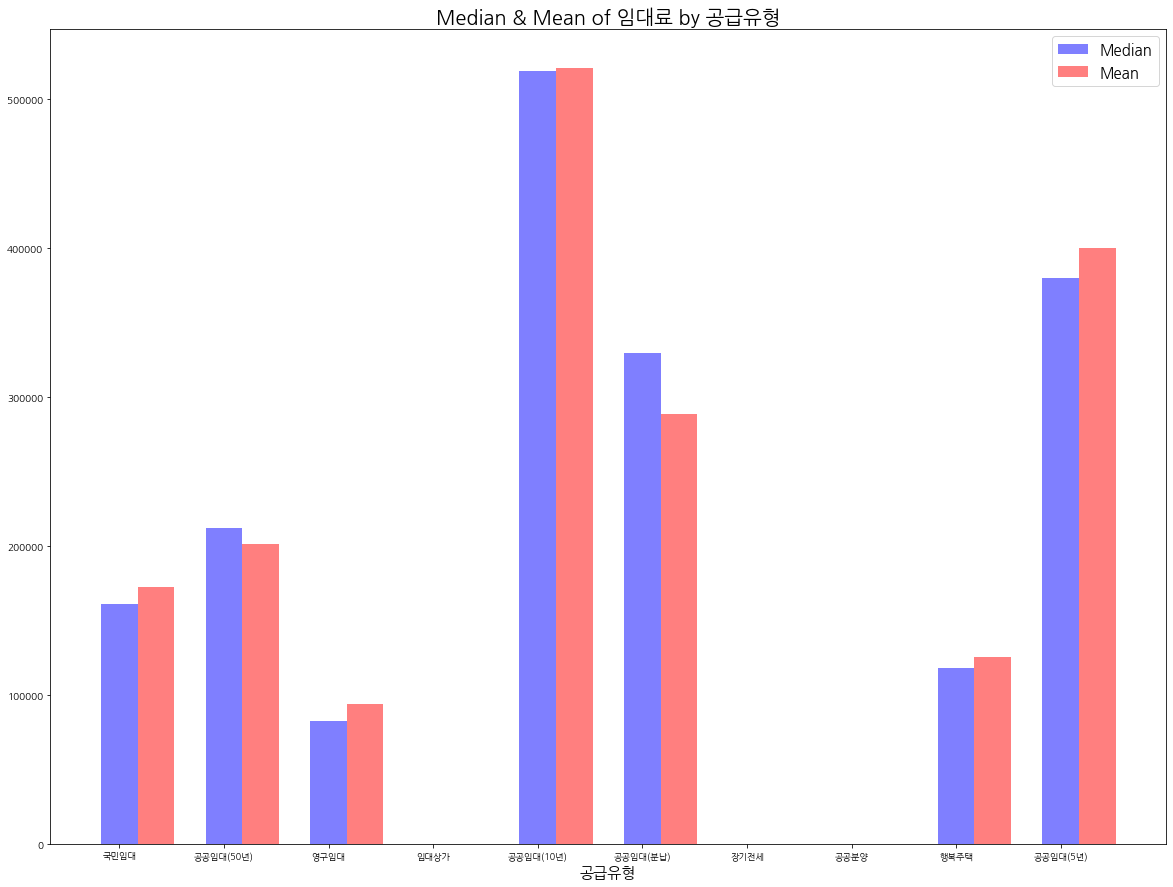

In [41]:
# 임대료
bar_width = 0.35
index = np.arange(len(result_median))

plt.figure(figsize=(20,15))

p1 = plt.bar(index,result_median['임대료'],
             width=bar_width,
             color='b',
             alpha=0.5,
             )
p2 = plt.bar(index + bar_width, result_mean['임대료'], 
             width=bar_width, 
             color='r', 
             alpha=0.5,
            )

plt.title('Median & Mean of 임대료 by 공급유형', fontsize=20)
plt.xlabel('공급유형', fontsize=15)
plt.xticks(index, [id.replace('_median','') for id in result_median.index], fontsize=9)
plt.legend((p1[0], p2[0]), ('Median', 'Mean'), fontsize=15)
plt.show()

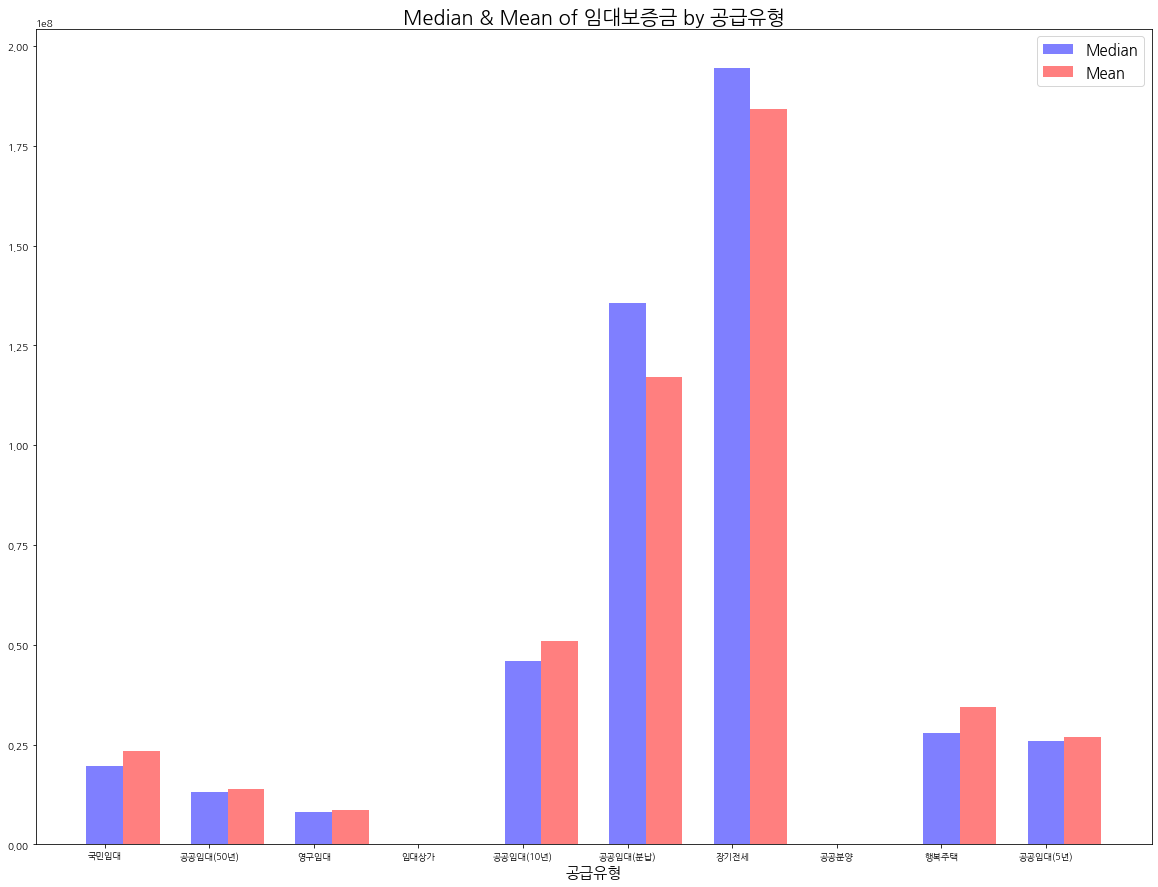

In [42]:
# 임대보증금

bar_width = 0.35
index = np.arange(len(result_median))

plt.figure(figsize=(20,15))

p1 = plt.bar(index,result_median['임대보증금'],
             width=bar_width,
             color='b',
             alpha=0.5,
             )
p2 = plt.bar(index + bar_width, result_mean['임대보증금'], 
             width=bar_width, 
             color='r', 
             alpha=0.5,
            )

plt.title('Median & Mean of 임대보증금 by 공급유형', fontsize=20)
plt.xlabel('공급유형', fontsize=15)
plt.xticks(index, [id.replace('_median','') for id in result_median.index], fontsize=9)
plt.legend((p1[0], p2[0]), ('Median', 'Mean'), fontsize=15)
plt.show()

#### 유형별 신청자격(소득기준) : https://www.seoulhousing.kr/html/0101003.do

공공임대 : 70% 이하
- 5년·10년 공공임대주택
    - 임대의무기간인 5년(10년)간 임대 후 분양 전환하여 입주자가 우선하여 소유권을 이전받을 수 있는 임대주택

- 50년 공공임대
    - 영구적인 임대를 목적으로 건설한 임대주택으로 임대개시일로부터 50년간 분양전환하지 않고 임대로만 거주할 수 있는 주택


    (수도권) 입주자저축(청약저축, 주택청약종합저축)에 가입하여 1년이 경과한 자로서 매월 약정납입일에 월 납입금을 12회 이상 납입한 자
    (수도권외 지역) 입주자저축(청약저축, 주택청약종합저축)에 가입하여 6개월이 경과한 자로서 매월 약정 납입일에 월 납입금을 6회 이상 납입한 자


> 

In [43]:
# https://www.myhome.go.kr/hws/portal/cont/selectContRentalView.do#guide=RH106
print(train.loc[train.공급유형.isin(['공공임대(5년)']),'전용면적'].min())
print(train.loc[train.공급유형.isin(['공공임대(5년)']),'전용면적'].max())

39.9
59.95


In [44]:
# https://www.myhome.go.kr/hws/portal/cont/selectContRentalView.do#guide=RH106
print(train.loc[train.공급유형.isin(['공공임대(10년)']),'전용면적'].min())
print(train.loc[train.공급유형.isin(['공공임대(10년)']),'전용면적'].max())

49.76
84.99


In [45]:
# https://www.myhome.go.kr/hws/portal/cont/selectContRentalView.do#guide=RH106
print(train.loc[train.공급유형.isin(['공공임대(50년)']),'전용면적'].min())
print(train.loc[train.공급유형.isin(['공공임대(50년)']),'전용면적'].max())

35.28
49.95


In [46]:
print(train.loc[train.공급유형.isin(['공공임대(분납)']),'전용면적'].min())
print(train.loc[train.공급유형.isin(['공공임대(분납)']),'전용면적'].max())

51.99
84.99


행복주택 : 해당세대의 전년도 도시근로자 가구원수별 월평균소득 100%이하인 자

* 대학생(본인+부모) 소득, 세대원 청년(본인) 소득, 맞벌이부부 120% 적용
    * 계층별 소득기준에 1인가구 20%p, 2인가구 10%p 각각 가산한 소득기준 적용

자산기준

보유 부동산(건물+토지), 자동차의 가액이 기준금액 이하인 자

- (총자산) 29,200만원이하(2021년도 기준)
- (자동차) 3,496만원이하(2021년도 기준)




In [47]:
# https://www.lh.or.kr/contents/cont.do?sCode=user&mPid=231&mId=232&menuYear=
print(train.loc[train.공급유형.isin(['행복주택']),'전용면적'].min())
print(train.loc[train.공급유형.isin(['행복주택']),'전용면적'].max())

16.02
44.97


국민임대 : 전년도 도시근로자 가구원수별 가구당 월평균소득의 70%(1인가구 90%, 2인가구 80%) 이하

50%, 70% 이하
(39㎡, 49㎡, 59㎡ 전용면적별 상이)

자산기준

- (총자산) 292,000만원 이하
- (자동차) 3,496만원 이하


In [48]:
# https://www.lh.or.kr/contents/cont.do
print(train.loc[train.공급유형=='국민임대','전용면적'].min())
print(train.loc[train.공급유형=='국민임대','전용면적'].max())

21.97
59.99


장기전세 : 전년도 도시근로자 가구당 월평균소득의 100퍼센트 이하 (건설형 장기전세주택은 70퍼센트 이하인 사람에게 우선적으로 공급)

In [49]:
# https://housing.seoul.go.kr/site/main/content/sh01_030600
print(train.loc[train.공급유형=='장기전세','전용면적'].min())
print(train.loc[train.공급유형=='장기전세','전용면적'].max())

23.32
59.94


영구임대 : 70% 이하
(수급자 등 공고문 1순위 대상자 우선))

In [50]:
# https://www.lh.or.kr/contents/cont.do
print(train.loc[train.공급유형=='영구임대','전용면적'].min())
print(train.loc[train.공급유형=='영구임대','전용면적'].max())

21.63
52.74


공공분양 : 전년도 도시 근로자 가구당 월평균소득 기준 이하인 자 (60㎡이하는 정보가 있는데..)

- (자격) 해당 지역에 거주하는 무주택세대구성원으로 입주자저축에 가입한 자
- (기타) 60㎡이하 주택에 청약하는 경우 '자산 및 소득' 요건을 만족해야 함

> 특별공급 : 120~140%

In [51]:
# https://www.lh.or.kr/contents/cont.do
# https://www.myhome.go.kr/hws/portal/cont/selectContLttotView.do#guide=LT304
print(train.loc[train.공급유형=='공공분양','전용면적'].min())
print(train.loc[train.공급유형=='공공분양','전용면적'].max())

74.94
84.97


In [52]:
train.loc[train.공급유형=='공공분양','자격유형'].value_counts()

D    7
Name: 자격유형, dtype: int64

In [53]:
print(train.loc[train.자격유형=='D','공급유형'].value_counts())
print(test.loc[test.자격유형=='D','공급유형'].value_counts())

임대상가    562
공공분양      7
Name: 공급유형, dtype: int64
임대상가    177
영구임대      3
Name: 공급유형, dtype: int64


In [54]:
# 공공임대(5년), 공공임대(10년), 공공임대(50년), 공공임대(분납), 공공분양 묶어버리자.
train.loc[train.공급유형.isin(['공공임대(5년)','공공임대(10년)','공공임대(50년)','공공임대(분납)','공공분양']),'공급유형'] = '공공임대(5년/10년/50년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)','공공임대(10년)','공공임대(50년)','공공임대(분납)','공공분양']),'공급유형'] = '공공임대(5년/10년/50년/분납/분양)'

In [55]:
# 장기전세, 행복주택 묶어버리자.
train.loc[train.공급유형.isin(['장기전세','행복주택']),'공급유형'] = '장기전세/행복주택'
test.loc[test.공급유형.isin(['장기전세','행복주택']),'공급유형'] = '장기전세/행복주택'

## 단지코드별로 agg

In [56]:
# 423개가 넘는 범주를 가지고 있다면, agg가 필요한 변수임
print(len(set(train['단지코드']))) 
print('='*50)
tr_nunique_groupby_danjicode = train.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)
tr_nunique_groupby_danjicode

423


총세대수                             423
임대건물구분                           456
지역                               423
공급유형                             484
전용면적                            1898
전용면적별세대수                        2230
공가수                              423
자격유형                             504
임대보증금                           1277
임대료                             1289
도보 10분거리 내 지하철역 수(환승노선 수 반영)     423
도보 10분거리 내 버스정류장 수               423
단지내주차면수                          423
등록차량수                            423
dtype: int64

In [57]:
# 150개가 넘는 범주를 가지고 있다면, agg가 필요한 변수임
print(len(set(test['단지코드'])))
print('='*50)
te_nunique_groupby_danjicode = test.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)
te_nunique_groupby_danjicode

150


총세대수                            150
임대건물구분                          157
지역                              150
공급유형                            165
전용면적                            693
전용면적별세대수                        797
공가수                             150
자격유형                            176
임대보증금                           459
임대료                             461
도보 10분거리 내 지하철역 수(환승노선 수 반영)    150
도보 10분거리 내 버스정류장 수              150
단지내주차면수                         150
dtype: int64

In [58]:
# agg 필요없는 변수들
tr_not_need_agg = ['단지코드']+tr_nunique_groupby_danjicode[tr_nunique_groupby_danjicode<=len(set(train['단지코드']))].index.tolist()
print(tr_not_need_agg)
print(len(tr_not_need_agg))
te_not_need_agg = ['단지코드']+te_nunique_groupby_danjicode[te_nunique_groupby_danjicode<=len(set(test['단지코드']))].index.tolist()
print(te_not_need_agg)
print(len(te_not_need_agg))

['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수']
8
['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수']
7


In [59]:
# agg 필요없는 변수들
df = train.loc[:,tr_not_need_agg].drop_duplicates()
print(df.shape)
df_test = test.loc[:,te_not_need_agg].drop_duplicates()
print(df_test.shape)
df.head()

(423, 8)
(150, 7)


,단지코드,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0
8,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0
15,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0
26,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0
32,C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0


In [60]:
# agg 필요한 변수들
tr_need_agg = tr_nunique_groupby_danjicode[tr_nunique_groupby_danjicode>len(set(train['단지코드']))].index.tolist()
print(tr_need_agg)
print(len(tr_need_agg))
te_need_agg = te_nunique_groupby_danjicode[te_nunique_groupby_danjicode>len(set(test['단지코드']))].index.tolist()
print(te_need_agg)
print(len(te_need_agg))

['임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']
7
['임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']
7


In [61]:
# continuous_variables : '전용면적','전용면적별세대수','임대보증금','임대료'
continuous_variables = ['전용면적','전용면적별세대수','임대보증금','임대료']
# https://rfriend.tistory.com/275
contfeature = '전용면적'
def reshaping_contfeature_by_pivot(input_df, from_data, contfeature):
    agg_dict_for_map = from_data.groupby(['단지코드'])[contfeature].agg(['mean','median','min','max','std','count','sum']).to_dict()
    result_df = input_df.copy()
    for key in agg_dict_for_map.keys():
        result_df[f'{contfeature}_{key}'] = input_df['단지코드'].map(agg_dict_for_map[key])
    return result_df

print(df.shape)
for contfeature in continuous_variables:
    df = reshaping_contfeature_by_pivot(df, train, contfeature)
df = df.fillna(0).reset_index(drop=True)   # row가 1개뿐인 group의 std는 null값이 도출됨.
print(df.shape)
print('='*50)
print(df_test.shape)
for contfeature in continuous_variables:
    df_test = reshaping_contfeature_by_pivot(df_test, test, contfeature)
df_test = df_test.fillna(0).reset_index(drop=True)   # row가 1개뿐인 group의 std는 null값이 도출됨.
print(df_test.shape)

(423, 8)
(423, 36)
(150, 7)
(150, 35)


In [62]:
# categorical_variables : '임대건물구분', '공급유형', '자격유형'
categorical_variables = ['임대건물구분', '공급유형', '자격유형']
def reshaping_catfeature_by_pivot(data, catfeature, value_col):
    result_df = data.drop_duplicates(['단지코드', catfeature]).assign(counter=1).pivot(index='단지코드', columns=catfeature, values=value_col).fillna(0)
    result_df.columns.name = None
    result_df = result_df.rename(columns={col:f"{catfeature}_{col}_{value_col}" for col in result_df.columns})
    return result_df

print(df.shape)
for catfeature in categorical_variables:
    reshaped_data = reshaping_catfeature_by_pivot(train, catfeature, value_col='counter').reset_index(drop=True)
    df = pd.concat([df,reshaped_data],axis=1)
print(df.shape)
print('='*50)
print(df_test.shape)
for catfeature in categorical_variables:
    reshaped_data = reshaping_catfeature_by_pivot(test, catfeature, value_col='counter').reset_index(drop=True)
    df_test = pd.concat([df_test,reshaped_data],axis=1)
print(df_test.shape)

(423, 36)
(423, 49)
(150, 35)
(150, 48)


# Pycaret Modeling

In [63]:
!pip uninstall pycaret -y

!pip install pycaret[full] ngboost shap

Uninstalling pycaret-2.3.1:
  Successfully uninstalled pycaret-2.3.1
  Using cached https://files.pythonhosted.org/packages/da/99/18f151991b0f06107af9723417c64e304ae2133587f85ea734a90136b4ae/pycaret-2.3.1-py3-none-any.whl
     |████████████████████████████████| 61kB 2.9MB/s 
ERROR: ray 1.4.0 has requirement protobuf>=3.15.3, but you'll have protobuf 3.12.4 which is incompatible.
ERROR: pandas-profiling 3.0.0 has requirement tqdm>=4.48.2, but you'll have tqdm 4.41.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [64]:
df.columns

Index(['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', '전용면적_mean', '전용면적_median',
       '전용면적_min', '전용면적_max', '전용면적_std', '전용면적_count', '전용면적_sum',
       '전용면적별세대수_mean', '전용면적별세대수_median', '전용면적별세대수_min', '전용면적별세대수_max',
       '전용면적별세대수_std', '전용면적별세대수_count', '전용면적별세대수_sum', '임대보증금_mean',
       '임대보증금_median', '임대보증금_min', '임대보증금_max', '임대보증금_std', '임대보증금_count',
       '임대보증금_sum', '임대료_mean', '임대료_median', '임대료_min', '임대료_max', '임대료_std',
       '임대료_count', '임대료_sum', '임대건물구분_상가_counter', '임대건물구분_아파트_counter',
       '공급유형_공공임대(5년/10년/50년/분납/분양)_counter', '공급유형_국민임대_counter',
       '공급유형_영구임대_counter', '공급유형_임대상가_counter', '공급유형_장기전세/행복주택_counter',
       '자격유형_A_counter', '자격유형_D_counter', '자격유형_E_counter',
       '자격유형_국민임대_공급대상_counter', '자격유형_영구임대_공급대상_counter',
       '자격유형_행복주택_공급대상_counter'],
      dtype='object')

In [65]:
# Compare Models
from pycaret.classification import *
from pycaret.regression import *
from pycaret.utils import check_metric

FEATS = ['총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', '전용면적_mean', '전용면적_median',
       '전용면적_min', '전용면적_max', '전용면적_std', '전용면적_count', '전용면적_sum',
       '전용면적별세대수_mean', '전용면적별세대수_median', '전용면적별세대수_min', '전용면적별세대수_max',
       '전용면적별세대수_std', '전용면적별세대수_count', '전용면적별세대수_sum', '임대보증금_mean',
       '임대보증금_median', '임대보증금_min', '임대보증금_max', '임대보증금_std', '임대보증금_count',
       '임대보증금_sum', '임대료_mean', '임대료_median', '임대료_min', '임대료_max', '임대료_std',
       '임대료_count', '임대료_sum', '임대건물구분_상가_counter', '임대건물구분_아파트_counter',
       '공급유형_공공임대(5년/10년/50년/분납/분양)_counter', '공급유형_국민임대_counter',
       '공급유형_영구임대_counter', '공급유형_임대상가_counter', '공급유형_장기전세/행복주택_counter',
       '자격유형_A_counter', '자격유형_D_counter', '자격유형_E_counter',
       '자격유형_국민임대_공급대상_counter', '자격유형_영구임대_공급대상_counter',
       '자격유형_행복주택_공급대상_counter']
reg1 = setup(data = df[FEATS], target = '등록차량수')
top5 = compare_models(n_select = 5, sort = 'MAE')
print('\n'.join([str(t) for t in top5]))
df_top_by_comparing = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,127.9983,3.653000e+04,188.5126,0.7513,0.3950,0.3751,0.507
llar,Lasso Least Angle Regression,128.0109,3.337946e+04,180.7341,0.7707,0.4096,0.3738,0.266
omp,Orthogonal Matching Pursuit,131.8740,3.455603e+04,184.3954,0.7570,0.5097,0.4200,0.014
xgboost,Extreme Gradient Boosting,133.9617,4.126403e+04,199.2220,0.7157,0.3900,0.3432,1.858
rf,Random Forest Regressor,133.9970,4.056077e+04,198.2411,0.7215,0.3950,0.3721,0.639
catboost,CatBoost Regressor,134.2421,4.105524e+04,198.7442,0.7277,0.4261,0.4137,8.564
gbr,Gradient Boosting Regressor,136.9346,4.263047e+04,203.3417,0.7069,0.4238,0.3966,0.171
lightgbm,Light Gradient Boosting Machine,138.3592,4.166734e+04,201.1598,0.7089,0.4693,0.3783,0.098
en,Elastic Net,143.4450,3.828633e+04,193.3125,0.7332,0.5339,0.4650,0.024
br,Bayesian Ridge,143.9871,3.995874e+04,198.0009,0.7221,0.4464,0.4495,0.016


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=5914, verbose=0, warm_start=False)
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, jitter=None, max_iter=500, normalize=True,
          positive=False, precompute='auto', random_state=5914, verbose=False)
OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
          

In [66]:
# df_top_by_comparing.to_csv('./output_pycaret/00_compare_models.csv',index=True)
df_top_by_comparing.index

Index(['et', 'llar', 'omp', 'xgboost', 'rf', 'catboost', 'gbr', 'lightgbm',
       'en', 'br', 'lasso', 'lr', 'ridge', 'ada', 'dt', 'huber', 'knn', 'par'],
      dtype='object')

In [72]:
# 모델들, grid score df, plot 등이 모두 저장되는 상위경로
from datetime import timedelta, timezone, datetime

now_time = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')
experiment_name = '_' + 'LB118_수정_pycaret으로_llar'

now_time += experiment_name

upper_dir_of_pycaret = f'/content/drive/MyDrive/dacon_parking_data/output_pycaret/{now_time}'
print(f"upper_dir_of_pycaret : {upper_dir_of_pycaret}")

fold=10
# FEATS = [c for c in final_df.columns if c not in ['단지코드']]
cat_features=[]
continuous_features=[]
target_feature = '등록차량수'

print(f'FEATS : {len(FEATS)}')
print(f"target : {target_feature}")
print(f'cat_features : {len(cat_features)}')
print(f'continuous_features : {len(continuous_features)}')

upper_dir_of_pycaret : /content/drive/MyDrive/dacon_parking_data/output_pycaret/0628_0125_LB118_수정_pycaret으로_llar
FEATS : 48
target : 등록차량수
cat_features : 0
continuous_features : 0


In [74]:
copy_train = train[['단지코드','등록차량수']].drop_duplicates().reset_index(drop=True)
no_nan_danjicode_idxes = copy_train.loc[copy_train['단지코드'].isin(no_nan_danjicode),:].index

holdout = df[FEATS].iloc[no_nan_danjicode_idxes]
holdout.shape

(378, 48)

# Training

In [75]:
settings = setup(
                data=df[FEATS], 
                target=target_feature, 
                train_size=0.95, 
                categorical_features=cat_features, 
                numeric_features=continuous_features,
                data_split_shuffle = True, # True가 default
                # fold_strategy = last_fold,
                # experiment_name=experiment_name,
                # log_experiment=False,   # compare_model 할 때에는 하이퍼파라미터가 어떻게 튜닝되었는지 볼 수 있어서 유용하다고 한다.
                )

# from ngboost import NGBClassifier
# ngc = NGBClassifier()
# ngboost = create_model(ngc)

model_name_list=['llar']   # 'et', 'catboost', 'rf', 'gbr', 'llar', 'omp', 'en', 'ada', 'br', 'lr', 'lasso', 'dt', 'ridge',
ensemble_method = 'blend_models'  # 'blend_models', 'stack_models' ->  (Regression : 'create_stacknet'), (Classifier : 'stack_models'),
meta_model_for_stack = 'xgboost' # If using stack_models

,Description,Value
0,session_id,1174
1,Target,등록차량수
2,Original Data,"(423, 48)"
3,Missing Values,False
4,Numeric Features,34
5,Categorical Features,13
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(401, 57)"


In [76]:
## Classification Models :  https://github.com/pycaret/pycaret/blob/master/pycaret/containers/models/classification.py
## Regression Modelss : https://github.com/pycaret/pycaret/blob/master/pycaret/containers/models/regression.py

## 각 단계마다 (create - tune - ensemble - finalize) 모델, 정보, plot 저장해주는 코드

def plot_save_pycaret_model(name, model,mode='tune'):
    # Feature Importance Plot 저장하기
    plot_dir = f'{upper_dir_of_pycaret}/plot_result'
    os.makedirs(plot_dir, exist_ok=True)
    os.chdir(plot_dir)
    # top10 feature
    feature_importance_plot = plot_model(model, plot = 'feature', save=True)
    os.rename(f'{plot_dir}/Feature Importance.png',f'{plot_dir}/{mode}_{name}_10_feature_importance.png')
    # all feature
    feature_importance_plot = plot_model(model, plot = 'feature_all', save=True)
    os.rename(f'{plot_dir}/Feature Importance (All).png',f'{plot_dir}/{mode}_{name}_all_feature_importance.png')

# def create_and_save_pycaret_model(name):
#     created_model = create_model(name, cross_validation = True)
#     # Display되는 score grid dataframe도 가져올 수가 있다. 
#     df_result_model = pull()
#     df_result_model.to_csv(f'{upper_dir_of_pycaret}/{name}_create_grid_df.csv')
#     # 실험결과를 저장하는 것도 가능하다.
#     save_experiment(f'{upper_dir_of_pycaret}/{name}_create_exp_result')
#     # 모델을 저장하는 것도 가능하다.
#     save_model(created_model, f'{upper_dir_of_pycaret}/{name}_model_saved')
#     return created_model

def tune_and_save_pycaret_model(name, model, optimize = 'MAE', fold = fold, n_iter = 10):
    print('Now Tuning the models....')
    tuned_model = tune_model(model, optimize = optimize, fold = fold, n_iter = n_iter)   # 
    # Display되는 score grid dataframe도 가져올 수가 있다. 
    df_result_model = pull()
    os.makedirs(f"{upper_dir_of_pycaret}/grid_df",exist_ok=True)
    df_result_model.to_csv(f'{upper_dir_of_pycaret}/grid_df/{name}_tuned_grid_df.csv')
    # 모델의 각종 plot을 저장하는 것도 가능하다.
    plot_save_pycaret_model(name, tuned_model, mode='tune')
    # 실험결과를 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/expr",exist_ok=True)
    try:
        save_experiment(f'{upper_dir_of_pycaret}/expr/{name}_tuned_exp_result')
    except:
        print('tuned model의 실험결과는 저장할 수 없습니다.')
    # 모델을 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/models",exist_ok=True)
    save_model(tuned_model, f'{upper_dir_of_pycaret}/models/{name}_tuned_model_saved')
    return tuned_model

def ensemble_and_save_pycaret_model(
                                    model_name_list,
                                    estimator_list,
                                    fold = fold,
                                    optimize = 'MAE',
                                    meta_model = None,
                                    mode = None,
                                    ):
    print('Now Ensemble the models....')
    if mode=='blend_models':
        ensembled_model = blend_models(estimator_list = estimator_list, fold = fold, optimize = optimize)
    elif mode=='stack_models':
        ensembled_model = stack_models(estimator_list = estimator_list, fold = fold, optimize = optimize, meta_model = meta_model)
    # Display되는 score grid dataframe도 가져올 수가 있다. 
    df_result_model = pull()
    name = '_'.join(model_name_list)
    os.makedirs(f"{upper_dir_of_pycaret}/grid_df",exist_ok=True)
    df_result_model.to_csv(f'{upper_dir_of_pycaret}/grid_df/{name}_ensembled_grid_df.csv')
    # 모델의 각종 plot을 저장하는 것도 가능하다.
    try:
        plot_save_pycaret_model(name, ensembled_model, mode='ensemble')
    except:
        print(f'ensemble model은 변수중요도 plot을 저장할 수 없습니다')
    # 실험결과를 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/expr",exist_ok=True)
    try:
        save_experiment(f'{upper_dir_of_pycaret}/expr/{name}_ensembled_exp_result')
    except:
        print(f'ensemble model은 실험결과를 저장할 수 없습니다')
    # 모델을 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/models",exist_ok=True)
    save_model(ensembled_model, f'{upper_dir_of_pycaret}/models/{name}_ensembled_model_saved')
    return ensembled_model

def finalize_and_save_pycaret_model(model_name_list,model,):
    print('Now Finalizing the model....')
    finalized_model = finalize_model(model)
    # Display되는 score grid dataframe도 가져올 수가 있다. 
    df_result_model = pull()
    name = '_'.join(model_name_list)
    os.makedirs(f"{upper_dir_of_pycaret}/grid_df",exist_ok=True)
    df_result_model.to_csv(f'{upper_dir_of_pycaret}/grid_df/{name}_finalized_grid_df.csv')
    # 모델의 각종 plot을 저장하는 것도 가능하다.
    try:
        plot_save_pycaret_model(name, finalized_model, mode='finalize')
    except:
        print(f'final model은 변수중요도 plot을 저장할 수 없습니다')
    # 실험결과를 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/expr",exist_ok=True)
    try:
        save_experiment(f'{upper_dir_of_pycaret}/expr/{name}_finalized_exp_result')
    except:
        print(f'final model은 실험결과를 저장할 수 없습니다')
    # 모델을 저장하는 것도 가능하다.
    os.makedirs(f"{upper_dir_of_pycaret}/models",exist_ok=True)
    save_model(finalized_model, f'{upper_dir_of_pycaret}/models/{name}_finalized_model_saved')
    return finalized_model


In [77]:
def ensemble_automl(
                    final_df,
                    holdout,
                    FEATS,
                    cat_features=[],
                    continuous_features=[],
                    seed=seed,
                    model_name_list = model_name_list,
                    ensemble_method = ensemble_method,
                    meta_model_for_stack = meta_model_for_stack,
                    settings = settings,
                    ):

    # final_df, holdout = datasets
    random.seed(seed)
    # fold_strategy = KFold(n_splits=10, shuffle=True, random_state=42)
    settings = settings

    # train_size만큼을 가지고 선언된 model_name_list 모델들을 학습을 함
    # create_model(name, sort='MAE', cross_validation = True)
    models_before_tune = [
                            create_model(
                                name, 
                                fold=fold,
                                cross_validation = True,
                                # cross_validation = False,
                                ) 
                            for name in model_name_list]
    # 앞서만든 모델들을 train_size만큼 가지고 튜닝함 (n_iter만큼 AutoML)
    # models_after_tune = [tune_model(model, optimize = 'MAE', fold = 10, n_iter = 10) for model in models_before_tune]
    models_after_tune = [tune_and_save_pycaret_model(name, model, optimize = 'MAE', fold = fold, n_iter = 10) for name, model in zip(model_name_list, models_before_tune)]


    # 튜닝된 모델들을 train_size만큼 가지고 앙상블
    if len(models_after_tune)<=1:
        ensembled = models_after_tune[0]
    else:
        ensembled = ensemble_and_save_pycaret_model(model_name_list,estimator_list=models_after_tune,fold = fold,optimize = 'MAE',method = method,meta_model = meta_model_for_stack,mode = ensemble_method)
    # elif ensemble_method=='blend_models':
    #     ensembled = blend_models(estimator_list = models_after_tune, fold = 10, method = 'soft', optimize = 'MAE')
    # elif ensemble_method=='stack_models':
    #     ensembled = stack_models(estimator_list = models_after_tune, meta_model = meta_model_for_stack, fold = 10, optimize = 'MAE')

    # 마지막 학습(Finalize)
    # 앞서 앙상블된 모델을 => setup으로 나눠져 쓰지않았던 valid까지 포함된 100퍼센트를 사용하여 fitting함
    final_model = finalize_and_save_pycaret_model(model_name_list,ensembled)

    metric_result = []
    prediction = predict_model(final_model, data=holdout[FEATS], )  # raw_score = True
    df_holdout_score = pull()

    os.makedirs(f"{upper_dir_of_pycaret}/holdout_score",exist_ok=True)
    df_holdout_score.to_csv(f'{upper_dir_of_pycaret}/holdout_score/finalize_holdout_score.csv')

    metric_result.append(f"HoldOut 데이터 MAE: {check_metric(prediction['등록차량수'], prediction['Label'], metric = 'MAE')}")
    return final_model, metric_result


In [78]:
final_model, metric_result = ensemble_automl(
                                            df,
                                            holdout,
                                            FEATS,
                                            cat_features,
                                            continuous_features,
                                            seed=seed,
                                            model_name_list=model_name_list,
                                            ensemble_method = ensemble_method,
                                            meta_model_for_stack = meta_model_for_stack,
                                            )

print(final_model)

print(f"ACC & AUC : ",'\n'.join(metric_result))

# <catboost.core.CatBoostRegressor object at 0x7ff1f02e06d0>
# ACC & AUC :  HoldOut 데이터 MAE: 60.0347

# LassoLars(alpha=1.0, copy_X=True, eps=0.1, fit_intercept=False, fit_path=True,
#           jitter=None, max_iter=500, normalize=False, positive=False,
#           precompute='auto', random_state=5914, verbose=False)
# ACC & AUC :  HoldOut 데이터 MAE: 120.0388

# HuberRegressor(alpha=0.0005, epsilon=1.1, fit_intercept=False, max_iter=100,
#                tol=1e-05, warm_start=False)
# ACC & AUC :  HoldOut 데이터 MAE: 121.9794


final model은 실험결과를 저장할 수 없습니다
Transformation Pipeline and Model Succesfully Saved
LassoLars(alpha=1.0, copy_X=True, eps=0.001, fit_intercept=True, fit_path=True,
          jitter=None, max_iter=500, normalize=True, positive=False,
          precompute='auto', random_state=1174, verbose=False)
ACC & AUC :  HoldOut 데이터 MAE: 123.3064


In [79]:
# 이번 Experiment Arg 관리
config_key = [
            'now_time',
            'seed','fold','model_name_list','ensemble_method','meta_model_for_stack',
            'cat_features','continuous_features','FEATS','LENGTH_FEATS',
            ]
config_value = [
                now_time,
                seed, fold, model_name_list, ensemble_method, meta_model_for_stack, 
                cat_features, continuous_features, FEATS,len(FEATS),]


In [80]:
cd /content/drive/MyDrive/dacon_parking_data


/content/drive/MyDrive/dacon_parking_data


# Submission

In [82]:
print(df.shape)
print(df_test.shape)

(423, 49)
(150, 48)


In [83]:
df['등록차량수'].max()


2550.0

In [85]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
# MAKE PREDICTION
prediction = predict_model(final_model, data=df_test[[f for f in FEATS if f not in ['등록차량수']]])
total_preds = prediction["Label"]
total_preds_dict = total_preds.to_dict()
sample_submission['num'] = sample_submission['code'].map(total_preds_dict)

# SAVE OUTPUT
prediction_name = f"{now_time}_NFeatures-{len(FEATS)}" # 

output_dir = f'{upper_dir_of_pycaret}/코드공유_submission'
os.makedirs(output_dir, exist_ok=True)    
write_path = os.path.join(output_dir, f"{prediction_name}.csv")
print("Saving Final Output CSVs...")
sample_submission.to_csv(f'{write_path}',index=False)
print(f"writing csv : {write_path}")

import json
# Save Config
write_path = os.path.join(upper_dir_of_pycaret, f"{prediction_name}_config.json")
config_dict = {k:v for k,v in zip(config_key, config_value)}
print("Saving Final Config Dict...")
## json파일 저장 ##
with open(write_path, "w") as fp:
    print(f"writing config : {write_path}")
    json.dump(config_dict, fp, indent=4)


Saving Final Output CSVs...
writing csv : /content/drive/MyDrive/dacon_parking_data/output_pycaret/0628_0125_LB118_수정_pycaret으로_llar/코드공유_submission/0628_0125_LB118_수정_pycaret으로_llar_NFeatures-48.csv
Saving Final Config Dict...
writing config : /content/drive/MyDrive/dacon_parking_data/output_pycaret/0628_0125_LB118_수정_pycaret으로_llar/0628_0125_LB118_수정_pycaret으로_llar_NFeatures-48_config.json
